# Pothole Detection Using YOLOv5

This contains the code and instructions for training and testing a YOLOv5 model to detect potholes in images. The model uses a custom dataset with XML annotations that are converted into YOLO format, followed by training and evaluation.

# Requirements

Make sure you have the following libraries installed:

1)ultralytics: For YOLOv5 model and training.

2)opencv-python: For image processing.

3)tensorflow and keras: For any deep learning or neural network requirements.

4)xml.etree.ElementTree: For parsing XML annotations.

In [2]:
!pip install ultralytics
!pip install opencv-python
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# Unzipping the file and studying about the structure of dataset.

1)Make sure your dataset (Pothole.zip) is uploaded to your environment and unzipped:

In [3]:
!unzip -q Pothole.zip #This code is helping in Unziping the file

# Dataset


The dataset consists of images of potholes along with XML annotations describing the bounding boxes. These XML files need to be converted to the YOLO format for use in training.

Dataset Structure

The directory structure should look like this:



    /content/
    /annotations/         # XML files containing annotations
    /images/              # Image files (.png)
    /labels/              # YOLO-formatted label files (.txt)
    /train/               # Folder containing training images and labels
        /images/
        /labels/
    /val/                 # Folder containing validation images and labels
        /images/
        /labels/
    /saved_model/         # Folder to save the trained model


2)Run the following script to convert the XML annotations into YOLO format:

In [4]:
import cv2 #Importing Open Source Computer Vision Library
import os
import xml.etree.ElementTree as ET #This library help in reading xml code


# Paths for your folders
annotations_folder = "/content/annotations"
images_folder = "/content/images"
labels_folder = "/content/labels"  # YOLO format labels will be saved here

# Make sure the labels folder exists
os.makedirs(labels_folder, exist_ok=True) #Checking that labels_folder is created ot not

# Mapping of classes, adjust it according to your dataset
class_mapping = {"pothole": 0}  # Example: 'pothole' class has the label 0


# Function to convert XML annotation to YOLO format
def convert_xml_to_yolo(xml_file, image_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get the image width and height
    image_path = os.path.join(images_folder, image_file)
    image = cv2.imread(image_path)
    h, w, _ = image.shape



    # Prepare the bounding boxes in YOLO format
    yolo_bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = class_mapping.get(class_name, None)  # get the class ID
        if class_id is None:
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Convert to YOLO format (normalized coordinates)
        x_center = (xmin + xmax) / 2.0 / w
        y_center = (ymin + ymax) / 2.0 / h
        width = (xmax - xmin) / float(w)
        height = (ymax - ymin) / float(h)

        # Append the converted bounding box to the list
        yolo_bboxes.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save the YOLO annotations to a file
    label_filename = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(labels_folder, label_filename)

    with open(label_path, "w") as label_file:
        for bbox in yolo_bboxes:
            label_file.write(f"{bbox}\n")

Annotation Format

Each XML file represents an object annotation for a single image.

The class name "pothole" is mapped to the label 0 for training.

In [5]:
# Iterate over all XML files in the annotations folder
for xml_file in os.listdir(annotations_folder):
    if xml_file.endswith(".xml"):
        # Get corresponding image file
        image_file = xml_file.replace(".xml", ".png")  # Or .jpg, based on your images
        xml_path = os.path.join(annotations_folder, xml_file)

        if os.path.exists(os.path.join(images_folder, image_file)):
            convert_xml_to_yolo(xml_path, image_file)

print("Conversion complete! YOLO annotations saved to:", labels_folder)

Conversion complete! YOLO annotations saved to: /content/labels


Split the Dataset:

Use the following code to split your dataset into training and validation sets (80%-20% split):

In [7]:
import random
import shutil


# Create folder
os.makedirs('/content/train/images', exist_ok=True)
os.makedirs('/content/train/labels', exist_ok=True)
os.makedirs('/content/val/images', exist_ok=True)
os.makedirs('/content/val/labels', exist_ok=True)


# Create list of Images
image_files = os.listdir('/content/images')
random.shuffle(image_files)  # random shuffle

# 80-20 split
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Train images and labels moving
for file in train_files:
    shutil.move(f'/content/images/{file}', f'/content/train/images/{file}')
    shutil.move(f'/content/labels/{file.replace(".png", ".txt")}', f'/content/train/labels/{file.replace(".png", ".txt")}')

# Validation images aur labels moving
for file in val_files:
    shutil.move(f'/content/images/{file}', f'/content/val/images/{file}')
    shutil.move(f'/content/labels/{file.replace(".png", ".txt")}', f'/content/val/labels/{file.replace(".png", ".txt")}')

print("80% training aur 20% validation updated!")


✅ 80% training aur 20% validation updated!


# Create data.yaml file

Create the data.yaml file with the following content:
This YAML file tells YOLOv5 where to find the training and validation data and the number of classes (nc: 1) with their names.

In [9]:
yaml_content = """
train: /content/train/images
val: /content/val/images

nc: 1
names: ['pothole']
"""

with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)

print("data.yaml ready is ready!")


✅ data.yaml ready is ready!


# Train the Model
Train the model using the following script:

In [10]:
from ultralytics import YOLO

# Load YOLOv5 model (pre-trained weights)
model = YOLO('yolov5s.pt')  # You can use yolov5s.pt for small model

# Train the model
model.train(data='/content/data.yaml', epochs=30, batch=16, imgsz=640)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 69.0MB/s]


Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/content/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, fo

100%|██████████| 755k/755k [00:00<00:00, 119MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics

YOLOv5s summary: 153 layers, 9,122,579 parameters, 9,122,563 gradients, 24.0 GFLOPs

Transferred 421/427 items from pretrained weights
Freezing layer 'model.24.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 358MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1685.4±962.2 MB/s, size: 619.0 KB)


train: Scanning /content/train/labels... 532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 532/532 [00:00<00:00, 886.79it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1836.6±1063.0 MB/s, size: 595.1 KB)


val: Scanning /content/val/labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 433.07it/s]

val: New cache created: /content/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.93G      1.684      2.358      1.568         13        640: 100%|██████████| 34/34 [00:15<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        133        339      0.388      0.401      0.331      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.73G      1.666      1.853      1.512         17        640: 100%|██████████| 34/34 [00:13<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


                   all        133        339      0.102      0.457        0.1      0.046

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.76G      1.687      1.818      1.538         20        640: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

                   all        133        339      0.208      0.136     0.0976     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       4.8G      1.676      1.659      1.527         13        640: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        133        339     0.0642      0.201     0.0476     0.0183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.82G      1.627      1.672      1.517         15        640: 100%|██████████| 34/34 [00:12<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        133        339      0.508      0.531      0.492      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.86G      1.588      1.518      1.486         14        640: 100%|██████████| 34/34 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        133        339      0.449      0.425       0.36      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.88G      1.583      1.495      1.474         20        640: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

                   all        133        339      0.485      0.378      0.398      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.92G      1.465      1.409        1.4         22        640: 100%|██████████| 34/34 [00:12<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        133        339      0.597       0.52      0.538      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.95G      1.438      1.375       1.38         10        640: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all        133        339      0.637      0.602       0.64      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.98G      1.489      1.372      1.395         32        640: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        133        339      0.653      0.511      0.572      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.01G      1.453      1.364      1.385         20        640: 100%|██████████| 34/34 [00:13<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        133        339      0.684      0.608      0.647      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.05G      1.442      1.341      1.377         15        640: 100%|██████████| 34/34 [00:12<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


                   all        133        339      0.681      0.578      0.609      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.08G      1.383      1.269      1.339         15        640: 100%|██████████| 34/34 [00:12<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        133        339      0.756      0.612      0.708      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.11G      1.382       1.24      1.328         22        640: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

                   all        133        339      0.689      0.572      0.631      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.14G      1.364      1.227      1.334         22        640: 100%|██████████| 34/34 [00:14<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

                   all        133        339      0.693      0.637      0.688      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.17G      1.333      1.159      1.302         42        640: 100%|██████████| 34/34 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        133        339      0.774      0.631      0.709      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       5.2G      1.316      1.138      1.291         29        640: 100%|██████████| 34/34 [00:12<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        133        339      0.722      0.587      0.653      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.24G      1.306      1.145      1.308         17        640: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        133        339      0.716       0.59      0.668      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.26G      1.273      1.083      1.254         25        640: 100%|██████████| 34/34 [00:12<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        133        339      0.697       0.59       0.67      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.29G      1.239      1.029      1.251         29        640: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        133        339       0.77      0.628      0.726       0.42


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.33G       1.24      1.064      1.242          7        640: 100%|██████████| 34/34 [00:14<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        133        339      0.742      0.652       0.74      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.36G      1.177       1.01      1.208         10        640: 100%|██████████| 34/34 [00:12<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        133        339      0.759      0.619      0.698        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.39G      1.166     0.9794      1.212          5        640: 100%|██████████| 34/34 [00:12<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        133        339      0.764      0.596      0.713      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.42G      1.147     0.9291      1.194          5        640: 100%|██████████| 34/34 [00:12<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        133        339      0.786      0.659      0.761      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.45G      1.127     0.8683      1.172         17        640: 100%|██████████| 34/34 [00:12<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        133        339      0.788      0.693      0.788      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.48G      1.099     0.8552      1.172         18        640: 100%|██████████| 34/34 [00:12<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        133        339       0.84      0.664      0.784      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.52G      1.068     0.8606      1.139          8        640: 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        133        339      0.872      0.664      0.797      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.55G      1.065     0.8183      1.136         13        640: 100%|██████████| 34/34 [00:12<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        133        339      0.884      0.655        0.8       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.58G      1.025     0.7735      1.128          8        640: 100%|██████████| 34/34 [00:12<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        133        339       0.82      0.696      0.802      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.61G      1.028     0.7887      1.116          6        640: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        133        339      0.828      0.699      0.809        0.5



30 epochs completed in 0.132 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,111,923 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


                   all        133        339      0.827      0.699      0.809      0.499
Speed: 0.3ms preprocess, 5.3ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793c12326b10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Save the Trained Model
After training, save the model for later use:

In [21]:
# Define the directory to save the model
save_path = '/content/saved_model'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save the trained model
model.save(os.path.join(save_path, 'best_model.pt'))  # Save to the new directory

print("Model successfully saved!")

Model successfully saved!


# Testing the Model


image 1/1 /content/val/images/potholes121.png: 384x640 10 potholes, 44.8ms
Speed: 2.3ms preprocess, 44.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'pothole'}
obb: None
orig_img: array([[[  0,  24,  11],
        [ 65,  92,  79],
        [  6,  33,  20],
        ...,
        [  4,  23,   8],
        [ 62,  81,  66],
        [ 67,  86,  71]],

       [[ 79, 107,  94],
        [ 11,  38,  25],
        [ 43,  71,  58],
        ...,
        [ 24,  43,  28],
        [ 79,  97,  84],
        [ 88, 107,  92]],

       [[ 14,  44,  31],
        [  9,  37,  24],
        [  6,  36,  23],
        ...,
        [ 79,  96,  83],
        [ 88, 104,  93],
        [ 86, 103,  90]],

       ...,

       [[ 71,  76,  77],
        [117, 122, 123],
        [ 97, 104, 107],
        ...,
        [103, 124, 139],
        [104, 125, 140],
   

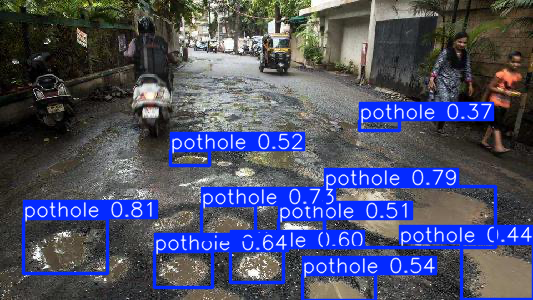

In [20]:
# Test karne ke liye images specify karen
results = model.predict(source='/content/val/images/potholes121.png', imgsz=640)
print(results)

# Results ko dekhna
results[0].show()  # Display the images with predictions
